## 이항 분류
### EarlyStopping, ModelCheckpoint, Confusion Matrix, ROC curve

In [36]:
# %autosave 0 
import warnings
warnings.filterwarnings(action='ignore') 

import os
import time

import numpy as np
import tensorflow as tf
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 파일 로딩
from tensorflow.keras.layers import Dense       # 전결합층
from tensorflow.keras.optimizers import Adam    # 가중치, bias 최적화
from tensorflow.keras.utils import plot_model   # 네트워크 입출력 시각화
from tensorflow.keras.callbacks import EarlyStopping # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 모델 저장

from sklearn.model_selection import train_test_split # 데이터 분할
from sklearn.metrics import confusion_matrix  # 혼돈행렬, 이항분류 시각화
from sklearn.metrics import roc_curve         # 분류 품질 시각화

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', family='Malgun Gothic')

# print(tf.__version__)

In [23]:
data = np.loadtxt('./wine.csv', delimiter=",", dtype=np.float64)
print(type(data))
print(data.shape)  # 6497행 13열

<class 'numpy.ndarray'>
(6497, 13)


In [24]:
X = data[:, 0:12]  # 0 ~ 11, 12개의 데이터 변수 추출
print(X.shape)     # 2차원 배열
Y = data[:, 12]    # 13번째 변수, class, 정답
print(Y.shape)     # 1차원 배열

(6497, 12)
(6497,)


In [25]:
# 데이터의 구성은 훈련, 검증, 테스트로 구성

In [26]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
# 데이터를 3그룹으로 분할: test 5% -> 95%(train 80%, validation 20%)
seed = 0
# stratify=Y: 0과 1의 분류 비율을 동일하게 데이터를 분할해줌.
# 95%: 분할대기(x_train_all), 5%: 테스트(x_test)
# x_train_all: 훈련 데이터 95% 분할 대기
# x_test: 테스트 데이터 5% 분할
# y_train_all: 훈련 target(class) 95% 분할 대기
# y_test: 테스트 target(class) 5% 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y,
                                                  stratify=Y,
                                                  test_size=0.05,
                                                  random_state=seed)
# 나머지 데이터 95%를 분할, 80%: 훈련(x_train), 20%: 검증(x_val)
# x_train: 훈련 데이터 80% 분할
# x_val: 검증 데이터 20% 분할
# y_train: 훈련 target(class) 80% 분할
# y_val: 검증 target(class) 20% 분할
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2,
                                                  random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(y_train[0:100]) # 검증 Target 100건만 출력

(4937, 12)
(4937,)
[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0.]


In [27]:
tf.random.set_seed(0)
model = Sequential()
model.add(Dense(10, input_dim=12, activation='relu')) # 기울기 소실 방지
model.add(Dense(1, activation='sigmoid')) # True/False
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

# patience=5: 학습 결과가 개선되지 않아도 학습을 진행할 횟수
# restore_best_weights=True: 학습 종료시 가장 우수한 가중치, 편향으로 저장
es= EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR): # 폴더가 존재하지 않으면 생성
    os.mkdir(MODEL_DIR) # 폴더 생성

# 03d: 좌측 0 padding 정수 3자리, .4f: 실수 소수점 4자리 
modelpath='./model/{epoch:03d}-{val_accuracy:.4f}.h5'  
# epoch:03d: 부족한 자리를 0으로 채우는 정수 형식
# val_accuracy:.4f: 소수이하 4째자리까지 표현 형식

# 검증 정확도가 개선되었을 때만 학습 모델 파일로 저장
# filepath=modelpath: 파일이 저장되는 경로와 파일명
# monitor='val_accuracy': 검증 정확도 기준으로 판단
# verbose=1: 기록되는 파일 정보 출력
# save_best_only=True: 검증 정확도가 개선되면 파일로 저장
mcp= ModelCheckpoint(filepath=modelpath,
                    monitor='val_accuracy',
                    verbose=1, save_best_only=True)

start = time.time()
hist = model.fit(x_train, y_train, validation_split=0.2, shuffle=True,
                epochs=1000, batch_size=1, callbacks=[es, mcp])
end=time.time()
print('Runtime: {0:.0f} 초'.format(end-start))
# patience=5 i5 2320: 114s, i9-10900kf: i9-11900H 54s,
# Ryzen 7 2700X: 121s,   Ryzen 5 3600: 54s

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
3949/3949 [==============================] - 4s 1ms/step - loss: 0.6955 - accuracy: 0.8939 - val_loss: 0.1459 - val_accuracy: 0.9433

Epoch 00001: val_accuracy improved from -inf to 0.94332, saving model to ./model\001-0.9433.h5
Epoch 2/1000
3949/3949 [==============================] - 4s 999us/step - loss: 0.2121 - accuracy: 0.9241 - val_loss: 0.1490 - val_accuracy: 0.9464

Epoch 00002: val_accuracy improved from 0.94332 to 0.94636, saving model to ./model\002-0.9464.h5
Epoch 3/1000
3949/3949 [=====

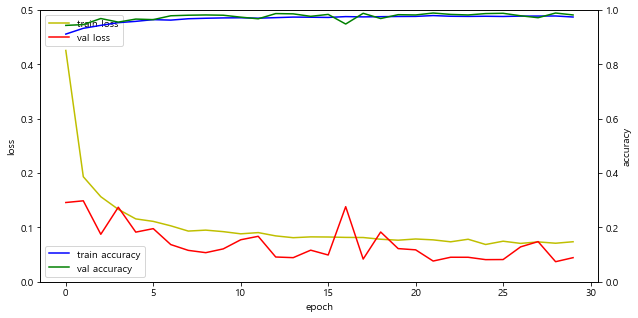

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [29]:
# verbose=0: 처리과정의 메시지 생략
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.05792376771569252 /정확도: 99.07692074775696 %


In [31]:
model = load_model('./model/022-0.9889.h5')
p = model.predict(x_test[0:100])
print(p.shape)
print(p[0:3])

(100, 1)
[[3.8185008e-06]
 [2.7455945e-07]
 [9.9047422e-01]]


In [32]:
for i in range(len(x_test[0:100])):
    fmt = '실제값: {0}, 예측값: {1}'
    print(fmt.format(y_test[i], p[i]), end='')
    
    # 임계값의 지정, 정확도를 참고하여 판단, 60%이상 합격: 0.6
    if (p[i] >= 0.5): 
        print('--> Red 와인')   # 1
    else:
        print('--> White 와인') # 0

실제값: 0.0, 예측값: [3.8185008e-06]--> White 와인
실제값: 0.0, 예측값: [2.7455945e-07]--> White 와인
실제값: 1.0, 예측값: [0.9904742]--> Red 와인
실제값: 0.0, 예측값: [0.00079319]--> White 와인
실제값: 1.0, 예측값: [0.9991443]--> Red 와인
실제값: 1.0, 예측값: [0.9963064]--> Red 와인
실제값: 0.0, 예측값: [0.00054967]--> White 와인
실제값: 0.0, 예측값: [0.00068578]--> White 와인
실제값: 0.0, 예측값: [0.4924161]--> White 와인
실제값: 0.0, 예측값: [0.00151291]--> White 와인
실제값: 1.0, 예측값: [0.9933299]--> Red 와인
실제값: 0.0, 예측값: [0.00286606]--> White 와인
실제값: 0.0, 예측값: [0.00019872]--> White 와인
실제값: 1.0, 예측값: [0.9988387]--> Red 와인
실제값: 0.0, 예측값: [0.00010122]--> White 와인
실제값: 0.0, 예측값: [0.00436956]--> White 와인
실제값: 0.0, 예측값: [0.00086004]--> White 와인
실제값: 1.0, 예측값: [0.9588444]--> Red 와인
실제값: 0.0, 예측값: [0.00031617]--> White 와인
실제값: 1.0, 예측값: [0.9995127]--> Red 와인
실제값: 0.0, 예측값: [3.5456505e-05]--> White 와인
실제값: 0.0, 예측값: [9.64284e-05]--> White 와인
실제값: 0.0, 예측값: [7.069777e-05]--> White 와인
실제값: 0.0, 예측값: [0.00041172]--> White 와인
실제값: 1.0, 예측값: [0.9956207]--> Red 와인
실제값: 0.0, 예측값

In [33]:
red = 0
white = 0
for i in range(len(y_test)):
    if y_test[i] == 1:  # red wine 인지 검사
        red = red + 1
    else:
        white = white + 1

print('Red wine:', red)
print('White wine:', white)

Red wine: 80
White wine: 245


In [34]:
# 결과 - 혼돈 행렬, # class 0우선으로 즉 오름차순으로 표가 생성
print(x_test.shape)
y_test_pred = model.predict_classes(x_test)  # 모델 테스트
c_matrix = confusion_matrix(y_test, y_test_pred) # 실제값, 예측값
print(type(c_matrix))
print(c_matrix)
# [[white wine 맞춘 갯수   white wine 틀린 갯수]
#  [red wine 틀린 갯수     red wine 맞춘 갯수]]

(325, 12)
<class 'numpy.ndarray'>
[[244   1]
 [  2  78]]


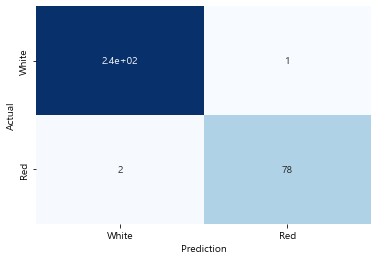

<Figure size 432x288 with 0 Axes>

In [37]:
ax = sb.heatmap(c_matrix, annot=True, 
                 xticklabels=['White', 'Red'], 
                 yticklabels=['White', 'Red'], cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()
plt.clf()
# [[white wine 맞춘 갯수   white wine 틀린 갯수]
#  [red wine 틀린 갯수     red wine 맞춘 갯수]]

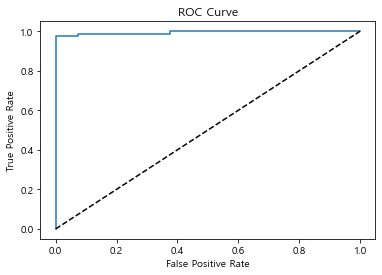

<Figure size 432x288 with 0 Axes>

In [38]:
# 결과 - ROC 곡선
y_test_pred_probs = model.predict(x_test)
# print(y_test_pred_probs)
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
plt.clf()